In [41]:
import zipfile
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import imageio
import cv2

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# open zip file
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Springboard - Capstone 3/rawData.zip', 'r')

# create folder with raw data
zip_ref.extractall('/content/BloodCellData')
zip_ref.close()

In [4]:
# Train Data Directory
Train_datadir = '../content/BloodCellData/Data/Train'
Test_datadir = '../content/BloodCellData/Data/Test'

print("Train Directory Folders:", os.listdir(Train_datadir))
print("Test Directory Folders:", os.listdir(Test_datadir))

Train Directory Folders: ['EOSINOPHIL', 'NEUTROPHIL', 'MONOCYTE', 'LYMPHOCYTE']
Test Directory Folders: ['EOSINOPHIL', 'NEUTROPHIL', 'MONOCYTE', 'LYMPHOCYTE']


In [66]:
# Image Size
image_width = 320
image_height = 240

# Split the data to training
train_images = tf.keras.utils.image_dataset_from_directory(
    Train_datadir,
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle=True,
    image_size=(image_height, image_width))

# Split the data to validation
validation_images = tf.keras.utils.image_dataset_from_directory(
    Train_datadir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    image_size=(image_height, image_width))

Found 9957 files belonging to 4 classes.
Using 7966 files for training.
Found 9957 files belonging to 4 classes.
Using 1991 files for validation.


In [67]:
class_names = train_images.class_names
print(class_names)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


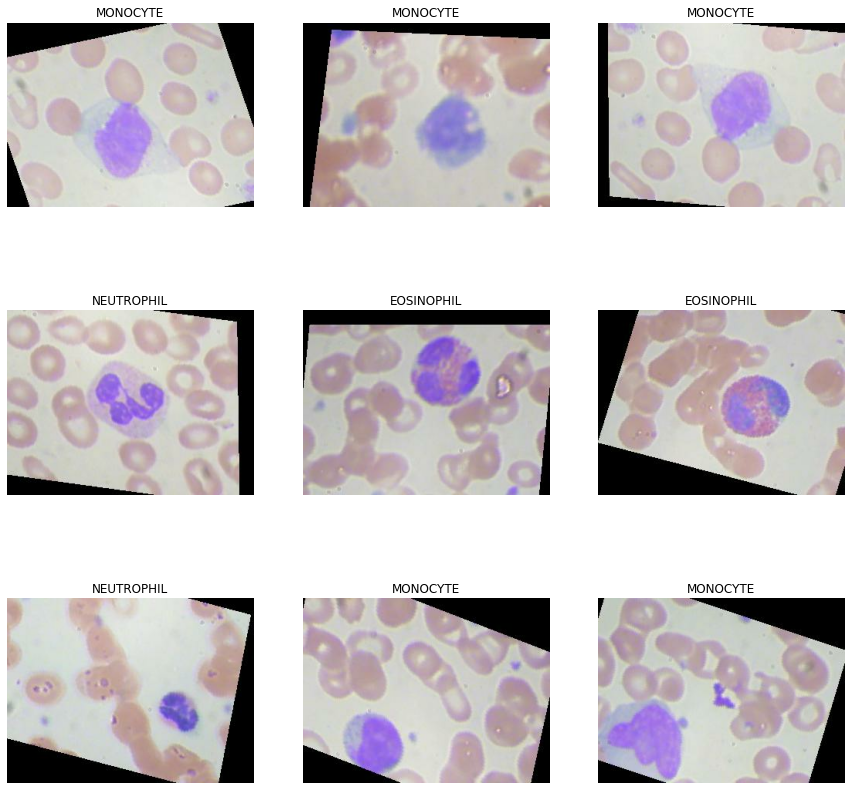

In [68]:
# Display images from train_image split
plt.figure(figsize=(15, 15))

for images, labels in train_images.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [69]:
# Display shape of the batches from the train_image split
for image_batch, labels_batch in train_images:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 240, 320, 3)
(32,)


In [70]:
# Using transfer learning base model Xception
base_model = tf.keras.applications.Xception(
    weights='imagenet',
    input_shape=(240, 320, 3),
    include_top=False
)

# Freezing base_model
base_model.trainable = False

inputs = tf.keras.Input(shape=(240, 320, 3))

# Rescales using Xception preprocessing to (-1,1)
x = tf.keras.applications.xception.preprocess_input(inputs)
x = base_model(x, training=False)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs, x)

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 240, 320, 3)]     0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 240, 320, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_4 (TFOpLam  (None, 240, 320, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 8, 10, 2048)       20861480  
                                                                 
 flatten_7 (Flatten)         (None, 163840)            0         
                                                                 
 dense_15 (Dense)            (None, 1024)              1677

In [71]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [72]:
epochs = 3
history = model.fit(train_images, epochs=epochs, validation_data=validation_images)

Epoch 1/3
249/249 [==============================] - 77s 300ms/step - loss: 3.8472 - accuracy: 0.4770 - val_loss: 0.8946 - val_accuracy: 0.6298
Epoch 2/3
249/249 [==============================] - 78s 311ms/step - loss: 0.8120 - accuracy: 0.6584 - val_loss: 0.7027 - val_accuracy: 0.6931
Epoch 3/3
249/249 [==============================] - 79s 318ms/step - loss: 0.6182 - accuracy: 0.7472 - val_loss: 0.7147 - val_accuracy: 0.7017


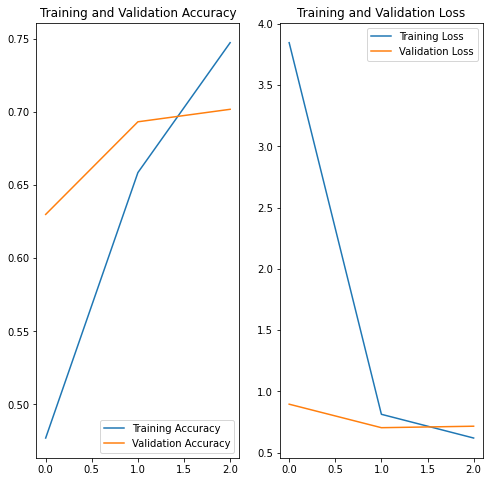

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [74]:
test_images = tf.keras.utils.image_dataset_from_directory(
    Test_datadir,
    label_mode='int',
    shuffle=True,
    image_size=(image_height, image_width))

Found 2487 files belonging to 4 classes.


In [75]:
loss, accuracy = model.evaluate(test_images)

78/78 [==============================] - 18s 225ms/step - loss: 1.7580 - accuracy: 0.4499
